# BNP Paribas Stock Price HMM Analysis

In this notebook, we will perform a Hidden Markov Model (HMM) analysis on BNP Paribas stock price data. The process is as follows:

1. **Data Reading & Preprocessing**:
   - We load BNP Paribas stock price data from a CSV file, ensuring the date is in correct datetime format.
   - We clean the dataset by removing invalid rows (where close price is missing or zero/negative).
   - We compute log prices and daily log returns.

2. **HMM Training**:
   - We use the [`hmmlearn`](https://hmmlearn.readthedocs.io/en/latest/) library to fit a Gaussian HMM with `n_components=10` hidden states.
     - Internally, `hmmlearn` uses the **Baum-Welch** algorithm for training when we call `.fit()`.

3. **Decoding Hidden States**:
   - After training, we decode the most likely sequence of hidden states for each day using the **Viterbi** algorithm when we call `.predict()`.

4. **Persisting HMM in Neo4j**:
   - We connect to a local Neo4j instance and clear any existing data.
   - We create nodes and relationships to represent the HMM parameters (hidden states, transitions, etc.).

5. **Forecasting**:
   - We define a function to forecast multiple steps ahead by using the model's transition probabilities and state means.

6. **Simulation & Comparison**:
   - We generate synthetic prices from the HMM and compare them to the actual first 100 days of data.
   - We also show an in-sample prediction approach as an additional demonstration.

Let's begin.

## 1. Data Reading and Preprocessing

In this step, we:
1. Read the CSV file containing BNP Paribas stock prices.
2. Convert the `Date` column to a datetime object and sort by date.
3. Clean the data by removing missing or invalid entries.
4. Compute the logarithm of prices (`LogClose`) and then the daily log returns (`LogRet`).

In [202]:
import pandas as pd
import numpy as np

# Read BNP Paribas data from CSV
data_bnp = pd.read_csv('../data/AMZN.csv')

# Convert 'Date' column to datetime
data_bnp['Date'] = pd.to_datetime(data_bnp['Date'])

# Sort values by date
data_bnp.sort_values('Date', inplace=True)

# Reset index after sorting
data_bnp.reset_index(drop=True, inplace=True)

# Remove rows with missing or invalid Close prices
data_bnp = data_bnp[data_bnp['Close'].notna()]  # remove rows missing close
data_bnp = data_bnp[data_bnp['Close'] > 0]      # remove zero or negative

# Compute log prices & daily log returns
data_bnp['LogClose'] = np.log(data_bnp['Close'])
data_bnp['LogRet']   = data_bnp['LogClose'].diff()

# Replace infinities and drop NaN rows caused by diff()
data_bnp.replace([np.inf, -np.inf], np.nan, inplace=True)
data_bnp.dropna(subset=['LogRet'], inplace=True)

# Display the final cleaned dataframe
data_bnp

,Date,Open,High,Low,Close,Adj Close,Volume,LogClose,LogRet
1,2019-01-03,76.000504,76.900002,74.855499,75.014000,75.014000,139512000,4.317675,-0.025566
2,2019-01-04,76.500000,79.699997,75.915497,78.769501,78.769501,183652000,4.366526,0.048851
3,2019-01-07,80.115501,81.727997,79.459503,81.475502,81.475502,159864000,4.400302,0.033777
4,2019-01-08,83.234497,83.830498,80.830498,82.829002,82.829002,177628000,4.416778,0.016476
5,2019-01-09,82.649002,83.389999,82.070000,82.971001,82.971001,126976000,4.418491,0.001713
...,...,...,...,...,...,...,...,...,...
499,2020-12-23,160.250000,160.506500,159.208496,159.263504,159.263504,41876000,5.070560,-0.006649
500,2020-12-24,159.695007,160.100006,158.449997,158.634506,158.634506,29038000,5.066603,-0.003957
501,2020-12-28,159.699997,165.199997,158.634506,164.197998,164.197998,113736000,5.101073,0.034470
502,2020-12-29,165.496994,167.532501,164.061005,166.100006,166.100006,97458000,5.112590,0.011517


### Reshape Observations
The `hmmlearn` library expects a 2D array of observations. Since we have 1D log returns, we reshape them into a 2D array.

In [203]:
observations = data_bnp['LogRet'].values.reshape(-1, 1)

if np.isnan(observations).any() or np.isinf(observations).any():
    raise ValueError("Observations still contain NaN or Inf - check data pipeline.")

observations

array([[-0.02556553],
       [ 0.04885112],
       [ 0.03377651],
       [ 0.01647588],
       [ 0.0017129 ],
       [-0.00193029],
       [-0.00950021],
       [-0.01433524],
       [ 0.034848  ],
       [ 0.00549089],
       [ 0.00559078],
       [ 0.00175835],
       [-0.03848004],
       [ 0.00479803],
       [ 0.00905026],
       [ 0.00940623],
       [-0.01975608],
       [-0.02723755],
       [ 0.04690978],
       [ 0.02850458],
       [-0.05532119],
       [ 0.00434413],
       [ 0.01549186],
       [-0.01124569],
       [-0.01591   ],
       [-0.01633083],
       [ 0.00174886],
       [ 0.02911927],
       [ 0.00121419],
       [-0.01063563],
       [-0.00910055],
       [ 0.01213416],
       [-0.00337258],
       [-0.00164123],
       [ 0.00745624],
       [ 0.00088219],
       [ 0.00207987],
       [ 0.00286191],
       [-0.00076803],
       [ 0.01926645],
       [ 0.01451375],
       [-0.00220745],
       [-0.01397063],
       [-0.02610244],
       [-0.00317241],
       [ 0

## 2. Connect to Neo4j
Next, we connect to our local Neo4j database. Before storing anything new, we clear out any existing data for a clean slate.

In [204]:
from py2neo import Graph

# Replace these credentials with your own
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

# Clear the graph
graph.run("MATCH (n) DETACH DELETE n")

(No data)

## 3. HMM Creation and Training
Here, we instantiate the Gaussian HMM with 10 hidden states and train it on our daily log returns. 

**Note**: `hmmlearn` uses the **Baum-Welch** algorithm internally when we call the `fit()` method.

In [205]:
from hmmlearn import hmm

# Définir les différents nombres d'états à tester
n_components_list = [7]
models = {}

for n_components in n_components_list:
    # Créer un modèle GaussianHMM
    model = hmm.GaussianHMM(
        n_components=n_components,
        covariance_type='full',  # use a full covariance matrix
        n_iter=100,             # maximum number of EM iterations
        random_state=42         # for reproducibility
    )

    # Entraîner le modèle avec les observations
    model.fit(observations)

    # Stocker le modèle entraîné
    models[n_components] = model
    print(f"Modèle HMM avec {n_components} états cachés entraîné.")


Model is not converging.  Current: 1317.1099171284086 is not greater than 1317.1240517387102. Delta is -0.014134610301653083


Modèle HMM avec 7 états cachés entraîné.


## 4. Decoding Hidden States
Once the HMM is trained, we use the `.predict()` method to apply the **Viterbi** algorithm and find the most likely sequence of hidden states for each day. We also extract parameters like the start probabilities, transition matrix, means, and covariances for each state.

In [206]:
# Decode hidden states using Viterbi
# hmmlearn uses the Viterbi algorithm under the hood in .predict()
hidden_states = model.predict(observations)

# Extract important parameters
start_probs = model.startprob_        # shape = (n_components,)
trans_probs = model.transmat_         # shape = (n_components, n_components)
means = model.means_.flatten()        # shape = (n_components,)
covars = model.covars_                # shape depends on covariance_type

# Display the transition matrix (rounded)
transition_matrix_3dec = np.round(trans_probs, 3)
print("Transition Matrix (3 decimals):")
print(transition_matrix_3dec)

Transition Matrix (3 decimals):
[[0.    0.    0.    0.    0.    0.    1.   ]
 [0.007 0.    0.993 0.    0.    0.    0.   ]
 [0.    0.    0.009 0.986 0.005 0.    0.   ]
 [0.    0.    0.979 0.001 0.    0.    0.021]
 [0.    0.    0.    0.999 0.    0.    0.001]
 [0.984 0.    0.008 0.008 0.    0.    0.   ]
 [0.    0.086 0.    0.    0.    0.914 0.   ]]


## 5. Persisting the HMM in Neo4j
We store:

1. A parent node to represent the entire HMM.
2. Nodes for each hidden state to store its mean, variance, and start probability.
3. Relationships for each transition probability from state *i* to state *j*.

In [207]:
# Clear any existing data again (optional, if you want a clean start)
graph.run("MATCH (n) DETACH DELETE n")

hmm_name = "BNP_HMM"

# A) Create/update a parent HMM node
create_hmm_query = """
MERGE (h:HMM {name: $hmm_name})
ON CREATE SET h.description = $description
RETURN h
"""

graph.run(
    create_hmm_query,
    hmm_name=hmm_name,
    description=f"GaussianHMM with {n_components} hidden states"
)

# B) Create a node for each state
for i in range(n_components):
    if covars[i].ndim > 1:
        var_value = covars[i].diagonal().mean()
    else:
        var_value = covars[i]

    create_state_query = """
    MERGE (s:State {hmm_name: $hmm_name, state_index: $state_index})
    ON CREATE SET
      s.mean = $mean,
      s.variance = $variance,
      s.start_prob = $start_prob
    RETURN s
    """

    graph.run(
        create_state_query,
        hmm_name=hmm_name,
        state_index=i,
        mean=float(means[i]),
        variance=float(var_value),
        start_prob=float(start_probs[i])
    )

# C) Create relationships for transition probabilities
for i in range(n_components):
    for j in range(n_components):
        prob_ij = float(trans_probs[i, j])

        create_rel_query = """
        MATCH (s1:State {hmm_name: $hmm_name, state_index: $i}),
              (s2:State {hmm_name: $hmm_name, state_index: $j})
        MERGE (s1)-[r:TRANSITION_TO {prob: $prob_ij}]->(s2)
        RETURN r
        """

        graph.run(
            create_rel_query,
            hmm_name=hmm_name,
            i=i,
            j=j,
            prob_ij=prob_ij
        )

print("HMM parameters have been stored in Neo4j.")

HMM parameters have been stored in Neo4j.


## 6. Posterior Probabilities and Forecasting
We obtain the posterior probabilities for each day and define a function to forecast future log returns by evolving the distribution over hidden states.

In [208]:
# Posterior probability of each state at each time step
posterior_probs = model.predict_proba(observations)

def forecast_log_returns(start_probs, transmat, means, steps=5):
    """
    Given a starting distribution over states, a transition matrix, and means per state,
    this function forecasts log returns for a specified number of steps.
    """
    dist = start_probs.copy()
    forecasts = []

    for _ in range(steps):
        # Weighted average log return
        forecast_r = np.sum(dist * means)
        forecasts.append(forecast_r)

        # Evolve the distribution one step ahead
        dist = dist @ transmat

    return forecasts

# Example usage: predict 5-day-ahead average log returns based on the final day's distribution
last_day_probs = posterior_probs[-1, :]
multi_step_logret = forecast_log_returns(
    start_probs=last_day_probs,
    transmat=model.transmat_,
    means=model.means_.flatten(),
    steps=5
)
print("Predicted log returns for the next 5 days:", multi_step_logret)

Predicted log returns for the next 5 days: [np.float64(0.0012210174539512792), np.float64(0.0020199399237452974), np.float64(0.0012492761846738785), np.float64(0.001960984979322091), np.float64(0.0013733964102311917)]


## 7. Simulation for the First 100 & 500 days Observations
We now generate a synthetic sequence of hidden states and observations from the trained HMM. Then we compare the simulated price path with the actual prices over the first 100 & 500 days.

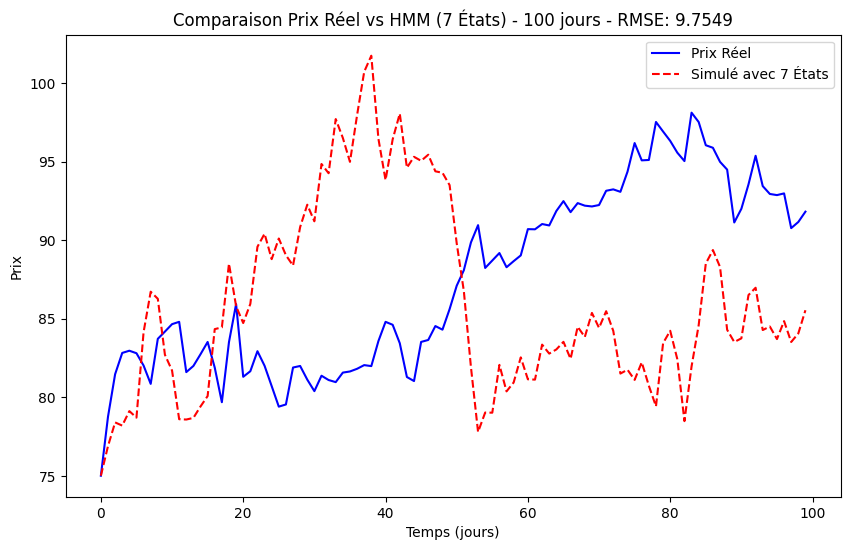

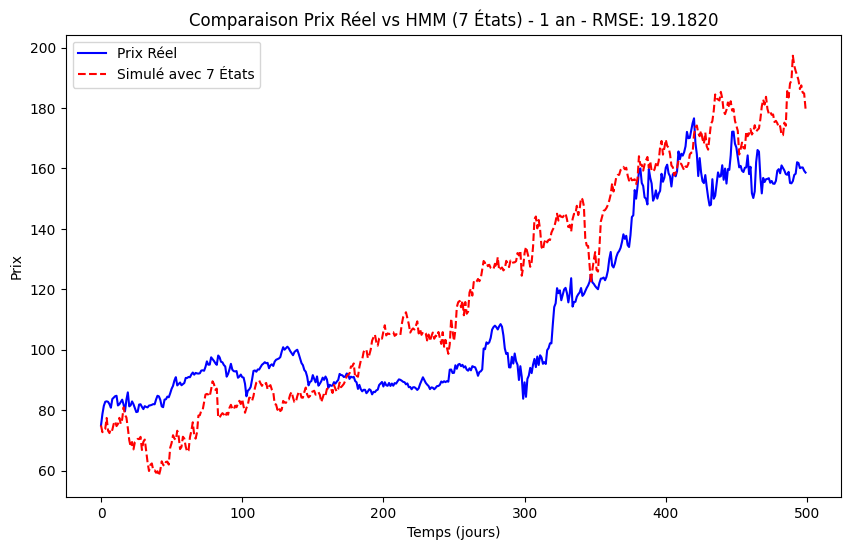


🔹 RMSE pour 100 jours:
   - 7 états: 9.7549

🔹 RMSE pour 1 an:
   - 7 états: 19.1820


In [209]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

def simulate_hmm(model, n):
    """
    Génère une séquence simulée de prix à partir d'un HMM entraîné sur `n` jours.
    """
    start_probs = model.startprob_
    trans_probs = model.transmat_
    means = model.means_
    covars = model.covars_
    n_states = model.n_components

    # 1) Échantillonner l'état initial
    state = np.random.choice(range(n_states), p=start_probs)
    sim_states = [state]
    sim_obs = []

    # 2) Tirer la première observation
    if model.covariance_type == 'full':
        std_dev = math.sqrt(covars[state, 0, 0])
    else:
        std_dev = math.sqrt(covars[state, 0])

    obs = np.random.normal(loc=means[state, 0], scale=std_dev)
    sim_obs.append(obs)

    # 3) Générer la suite des observations
    for _ in range(n - 1):
        state = np.random.choice(range(n_states), p=trans_probs[state])
        sim_states.append(state)

        if model.covariance_type == 'full':
            std_dev = math.sqrt(covars[state, 0, 0])
        else:
            std_dev = math.sqrt(covars[state, 0])

        obs = np.random.normal(loc=means[state, 0], scale=std_dev)
        sim_obs.append(obs)

    return np.array(sim_states), np.array(sim_obs)

# Définir les longueurs de simulation
sim_lengths = {"100 jours": 100, "1 an": 500}
actual_prices = {"100 jours": data_bnp['Close'].values[:100], "1 an": data_bnp['Close'].values[:500]}

# Stocker les RMSE
rmse_results = {length: {} for length in sim_lengths}

for n_states, model in models.items():
    for period_name, sim_length in sim_lengths.items():
        # Simuler les observations
        sim_states, sim_obs = simulate_hmm(model, n=sim_length)

        # Convertir les retours simulés en prix
        initial_price = actual_prices[period_name][0]
        simulated_prices = [initial_price]

        for i in range(1, sim_length):
            next_price = simulated_prices[-1] * np.exp(sim_obs[i])
            simulated_prices.append(next_price)

        # Calcul du RMSE
        rmse = math.sqrt(mean_squared_error(actual_prices[period_name], simulated_prices))
        rmse_results[period_name][n_states] = rmse

        # Affichage du graphique
        plt.figure(figsize=(10, 6))
        plt.plot(range(sim_length), actual_prices[period_name], label='Prix Réel', color='blue')
        plt.plot(range(sim_length), simulated_prices, label=f'Simulé avec {n_states} États', linestyle='--', color='red')
        plt.title(f"Comparaison Prix Réel vs HMM ({n_states} États) - {period_name} - RMSE: {rmse:.4f}")
        plt.xlabel("Temps (jours)")
        plt.ylabel("Prix")
        plt.legend()
        plt.show()

# Afficher les RMSE pour 100 jours et 10 ans
for period_name, rmse_dict in rmse_results.items():
    print(f"\n🔹 RMSE pour {period_name}:")
    for n, rmse in rmse_dict.items():
        print(f"   - {n} états: {rmse:.4f}")


## 8. In-Sample Prediction Approach 
Finally, we demonstrate an in-sample prediction approach for the first 100 days:
1. We decode the hidden states from the *actual* returns.
2. For day *t*, we use the hidden state from day *(t-1)* to retrieve its mean log return.
3. We exponentiate and multiply to get an estimated price for day *t*.

This shows how the HMM might perform if we continuously updated our knowledge of the hidden state using actual data.

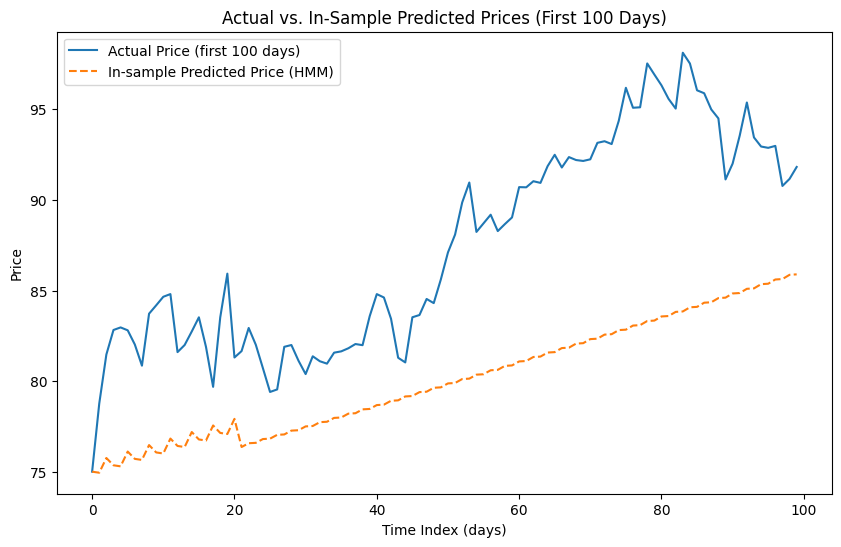

In [210]:
# In-sample prediction
observations_100 = observations[:100]
hidden_states_100 = model.predict(observations_100)
in_sample_prices = np.zeros(100)
actual_prices_100 = data_bnp['Close'].values[:100]

# Use the actual price on day 0 as the starting point
in_sample_prices[0] = actual_prices_100[0]

# For each subsequent day, use the previous day's state to determine the mean return
for t in range(1, 100):
    st = hidden_states_100[t-1]
    mu_t = model.means_[st, 0]
    in_sample_prices[t] = in_sample_prices[t-1] * np.exp(mu_t)

# Plot actual vs in-sample predicted
plt.figure(figsize=(10, 6))
plt.plot(range(100), actual_prices_100, label='Actual Price (first 100 days)')
plt.plot(range(100), in_sample_prices, label='In-sample Predicted Price (HMM)', linestyle='--')
plt.title("Actual vs. In-Sample Predicted Prices (First 100 Days)")
plt.xlabel("Time Index (days)")
plt.ylabel("Price")
plt.legend()
plt.show()